In [7]:
import numpy as np 
import pandas as pd 
import pickle

# visualizatioion pkg 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys
sys.path.append('..')

from utils.viz import viz 
from utils.model import *  
from utils.fig_fn import *
viz.get_style()

In [8]:
exp = 'exp2'
agents = ['rmPG_fea', 'caPG_fea', 'ecPG_fea']
method = 'mle'
dpi = 300

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


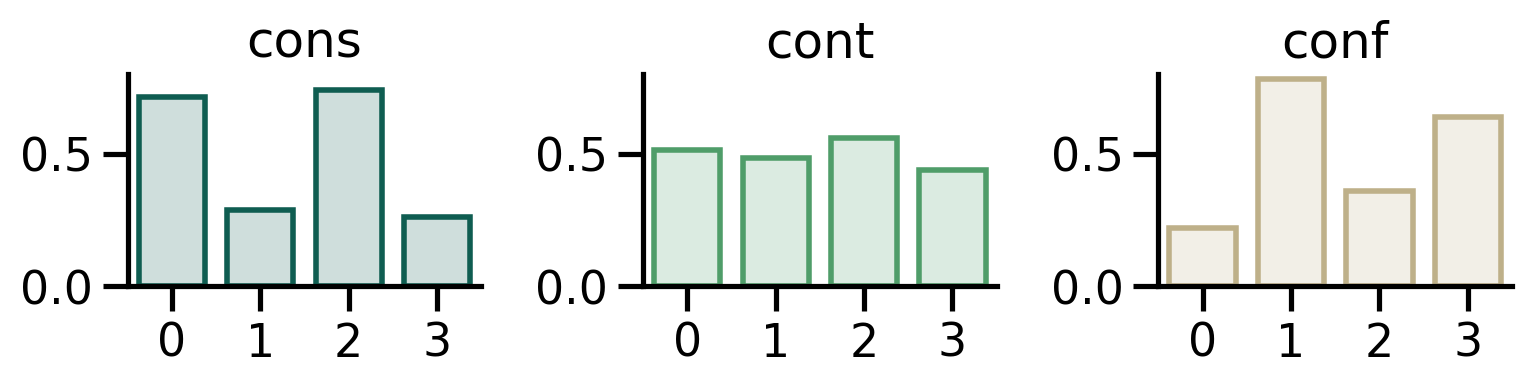

In [9]:
def sim_probe_bar(exp, agent_name, block_types):
    voi = {}
    for block_type in block_types:
        psi, rho, lmbda = 11, 4, .1
        fname = f'../simulations/{exp}/{agent_name}/simsubj-{block_type}_voi'
        fname += f'-α_ψ={psi}-α_ρ={rho}-λ={lmbda}.pkl'
        with open(fname, 'rb')as handle: voi[block_type] = pickle.load(handle)
    nr, nc = 1, len(block_types)
    fig, axs = plt.subplots(nr, nc, figsize=(8, 2.7))
    for b, block_type in enumerate(block_types):
        ax = axs[b]
        pol = voi[block_type]['pol'][59][4, :]
        sns.barplot(x=[0, 1, 2, 3], y=pol,
                        errorbar='se', linewidth=2, width=.75,
                        edgecolor=viz.Pal_type[b], 
                        facecolor=viz.Pal_type[b].tolist()+[.2],
                        color='w', ax=ax)
        ax.legend().remove()
        ax.set_box_aspect(.6)
        ax.set_title(f'{block_type}')
        ax.set_ylim([0, .8])
    fig.tight_layout()

sim_probe_bar(exp, 'ecPG_fea_sim', block_types=['cons', 'cont', 'conf'])
plt.savefig(f'../figures/{exp}/Fig6B_probPolicyBar_RDPG.pdf', dpi=dpi)

### Fig5C: Human and model probe policy 

In [10]:
def viz_Probe(exp, agents, method, goodPoor=None):
    n = len(agents) 
    fig, axs = plt.subplots(n, 3, figsize=(2.5*3, n*2.3), sharey=True)
    for i, agent in enumerate(agents):
        if agent == 'human':
            fname = f'{pth}/../data/{exp}-human.csv'
            s = 1
        else:
            fname = f'{pth}/../simulations/{exp}/{agent}/sim-{method}.csv'
            s = 10
        data = pd.read_csv(fname, index_col=0)
        sel_data = data.query('group=="probe"').reset_index()

        for j, cond in enumerate(['cons', 'cont', 'conf']):
            ax = axs[i, j] if n > 1 else axs[j]
            sdata = sel_data.query(f'block_type=="{cond}"')
            if goodPoor is not None: sdata = sdata.query(f'goodPoor=="good"') 
            gdata = sdata.groupby(by=['sub_id', 'a', 'block_type']).count()['r'].reset_index()
            ptable = gdata.pivot_table(values='r', index='sub_id', columns='a').fillna(0) / (6*s)
            ptable.columns = [0, 1, 2, 3]
            ptable = ptable.reset_index()
            ptable = ptable.melt(id_vars='sub_id', value_vars=[0, 1, 2, 3]
                        ).rename(columns={'variable': 'a', 'value':'prop'})
        
            sns.stripplot(x='a', y='prop', data=ptable, 
                        color=viz.Pal_type[j], #dodge=True, 
                        edgecolor='gray', size=2.2,
                        jitter=True, alpha=.7,
                        legend=False, zorder=2,
                        ax=ax)
            v = sns.violinplot(x='a', y='prop', data=ptable,
                        errorbar='se', linewidth=1, 
                        inner=None, 
                        capsize=.3, errwidth=1.5, alpha=.45,
                        color=viz.Pal_type[j],
                        ax=ax)
            plt.setp(v.collections, alpha=.35, edgecolor='none')
            sns.barplot(x='a', y='prop', data=ptable,
                        errorbar='se', linewidth=2, width=.75,
                        edgecolor=viz.Pal_type[j], 
                        facecolor=viz.Pal_type[j].tolist()+[.2],
                        capsize=.05, errwidth=2.5, errcolor=[.2, .2, .2],
                        color='w', ax=ax)
            ax.set_box_aspect(.9)
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_yticks([0, .25, .5, .75, 1])
            ax.set_yticklabels([0, None, .5, None, 1])
            ax.set_ylim([0, 1.1])
            if j==1: ax.set_title(eval(agent).name)
            ax.spines['left'].set_position(('axes',-0.05))
            ax.set_xticklabels([r'$a_1$', r'$a_2$', r'$a_3$', r'$a_4$'])
    fig.tight_layout()

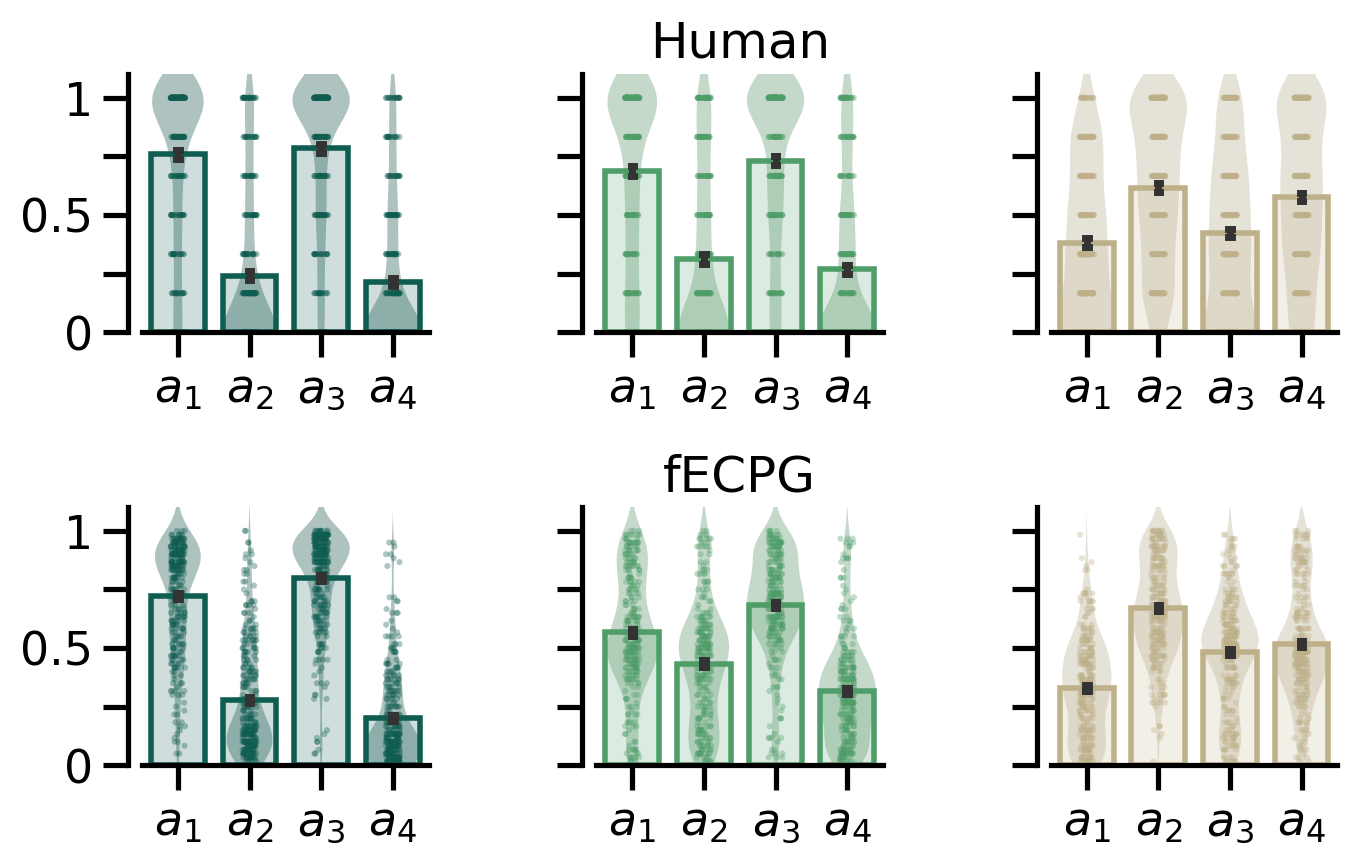

In [12]:
viz_Probe(exp, agents=['human', 'ecPG_fea'], method=method)
plt.savefig(f'../figures/{exp}/Fig6C_probeData.pdf', dpi=dpi)

### Fig5D: correlation matrix 

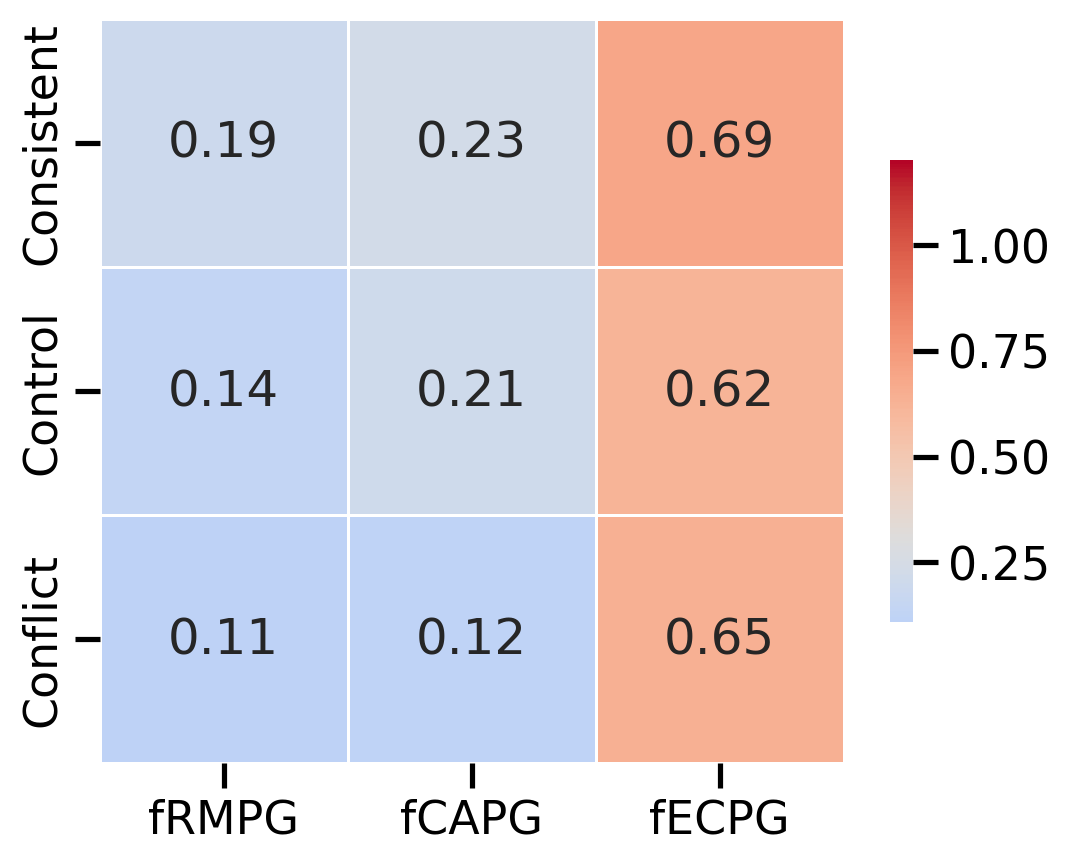

In [13]:
corr_matrix(exp, agents, method)
plt.savefig(f'../figures/{exp}/Fig6D_corrMat.pdf', dpi=dpi)